In [ ]:
# Import necessary libraries
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#dataset paths
base_dir = "c:/SRM/ML/ML_Envision/dataset"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

#image size and batch size
IMG_SIZE = (224, 224)  # Resize images to 224x224
BATCH_SIZE = 32

# Creating ImageDataGenerators for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

#Loading the datsets
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical' 
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  #Keeping the order consistent for evaluation
)

# Display class indices
print("Class indices:", train_data.class_indices)

Found 10063 images belonging to 3 classes.
Found 2874 images belonging to 3 classes.
Found 1441 images belonging to 3 classes.
Class indices: {'normal': 0, 'pnemo': 1, 'tb': 2}


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load the pre-trained MobileNetV2 model without the top layer
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model to retain pre-trained weights
base_model.trainable = False

# Building the model
model = Sequential([
    base_model,  # Add the pre-trained base model
    GlobalAveragePooling2D(),  # Global average pooling layer
    Dropout(0.5),  # Dropout for regularization
    Dense(128, activation='relu'),  # Fully connected layer
    Dropout(0.5),  # Dropout for regularization
    Dense(train_data.num_classes, activation='softmax')  # Output layer for multi-class classification
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10, 
    steps_per_epoch=train_data.samples // BATCH_SIZE,
    validation_steps=val_data.samples // BATCH_SIZE
)

# Evaluation on test data
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 10s 1us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

c:\SRM\ML\ML_Envision\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 494s 2s/step - accuracy: 0.7340 - loss: 0.7203 - val_accuracy: 0.8350 - val_loss: 0.4130
Epoch 2/10
  1/314 ━━━━━━━━━━━━━━━━━━━━ 1:22 265ms/step - accuracy: 0.6875 - loss: 0.6574

c:\SRM\ML\ML_Envision\venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


314/314 ━━━━━━━━━━━━━━━━━━━━ 38s 120ms/step - accuracy: 0.6875 - loss: 0.6574 - val_accuracy: 0.8385 - val_loss: 0.4107
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 305s 972ms/step - accuracy: 0.8039 - loss: 0.5035 - val_accuracy: 0.8409 - val_loss: 0.3858
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 38s 119ms/step - accuracy: 0.9062 - loss: 0.3017 - val_accuracy: 0.8392 - val_loss: 0.3868
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 301s 959ms/step - accuracy: 0.8168 - loss: 0.4725 - val_accuracy: 0.8511 - val_loss: 0.3672
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 36s 113ms/step - accuracy: 0.8125 - loss: 0.4352 - val_accuracy: 0.8490 - val_loss: 0.3680
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 286s 909ms/step - accuracy: 0.8179 - loss: 0.4725 - val_accuracy: 0.8448 - val_loss: 0.3810
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 36s 114ms/step - accuracy: 0.8125 - loss: 0.3201 - val_accuracy: 0.8455 - val_loss: 0.3791
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 286s 910ms/step - accuracy: 0.8314 - loss: 0.4343 -

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

# Get predictions for the test data
y_pred_probs = model.predict(test_data)  
y_pred_classes = np.argmax(y_pred_probs, axis=1) 
y_true = test_data.classes  

# Get class labels
class_labels = list(test_data.class_indices.keys())

# Classification report (Precision, Recall, F1-Score)
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 472ms/step
Classification Report:
              precision    recall  f1-score   support

      normal       0.81      0.96      0.87       752
       pnemo       0.93      0.78      0.85       578
          tb       0.97      0.53      0.69       111

    accuracy                           0.85      1441
   macro avg       0.90      0.76      0.80      1441
weighted avg       0.87      0.85      0.85      1441



46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 418ms/step


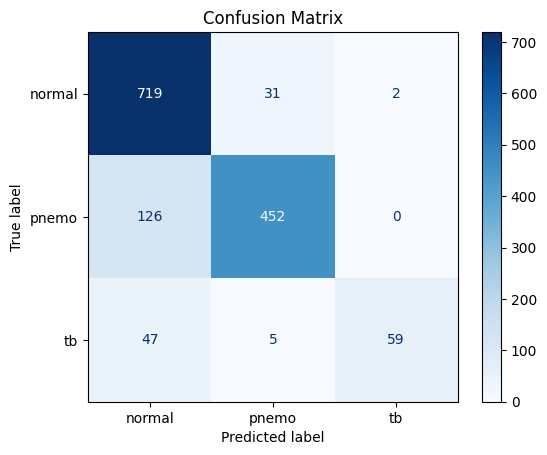

In [6]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get predictions for the test data
y_pred_classes = np.argmax(model.predict(test_data), axis=1)  # Predicted class labels
y_true = test_data.classes  # True class labels

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_data.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 424ms/step


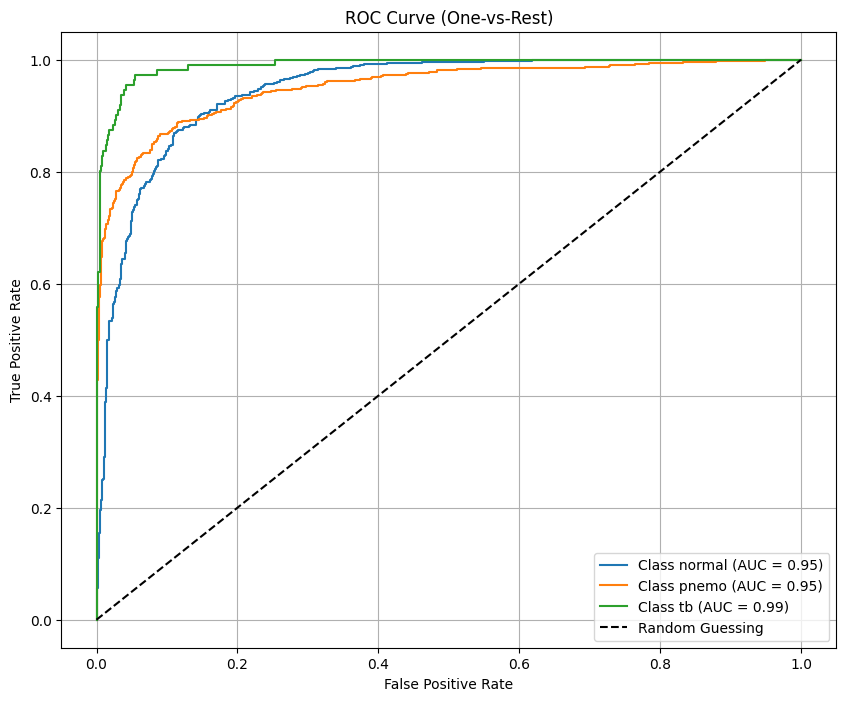

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Get predictions for the test data
y_pred_probs = model.predict(test_data)  
y_true = test_data.classes 
class_labels = list(test_data.class_indices.keys())  

# One-vs-Rest (OvR) ROC Curve for multi-class classification
plt.figure(figsize=(10, 8))
for i, class_label in enumerate(class_labels):
    # Compute ROC curve and AUC for each class
    fpr, tpr, _ = roc_curve(y_true == i, y_pred_probs[:, i])
    auc = roc_auc_score(y_true == i, y_pred_probs[:, i])
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {auc:.2f})")

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")

# Add labels, title, and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Path to the image you want to test
image_path = r"C:\SRM\ML\ML_Envision\dataset\test\normal\CHNCXR_0235_0.png"  #image path 

# Load and preprocess the image
img = image.load_img(image_path, target_size=IMG_SIZE)  # Resize to match model input size
img_array = image.img_to_array(img)  # Convert to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize pixel values to [0, 1]

# Predict the class
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]  
class_labels = list(test_data.class_indices.keys()) 

# Displaying the result
print(f"Predicted Class: {class_labels[predicted_class]}")
print(f"Class Probabilities: {predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Predicted Class: normal
Class Probabilities: [[0.6118199  0.03561953 0.35256058]]
